In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load cleaned data
df = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_hourly.csv', index_col='Datetime', parse_dates=True)
print(f" Loaded: {len(df):,} hourly records")
print(f" Date range: {df.index.min()} to {df.index.max()}")

# Device columns
device_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
device_names = ['Kitchen', 'Laundry', 'HVAC']

 Loaded: 34,589 hourly records
 Date range: 2006-12-16 17:00:00 to 2010-11-26 21:00:00


In [3]:
# Aggregating Data for Dashboards

# Hourly (last 24 hours)
hourly_recent = df.tail(24).copy()
print(f" Loaded: Hourly data for last 24 hours")
# Daily (last 30 days)
daily = df.resample('D').mean().tail(30)
print(f" Loaded: Daily data for last 30 days")

# Weekly (last 12 weeks)
weekly = df.resample('W').mean().tail(12)
print(f" Loaded: Weekly data for last 12 weeks")

# Monthly (all months available)
monthly = df.resample('M').mean()
print(f" Loaded: Monthly data for {len(monthly)} months")

 Loaded: Hourly data for last 24 hours
 Loaded: Daily data for last 30 days
 Loaded: Weekly data for last 12 weeks
 Loaded: Monthly data for 48 months


In [4]:
# Calculating Energy Statistics

# Overall statistics
stats = {
    'avg_power': df['Global_active_power'].mean(),
    'max_power': df['Global_active_power'].max(),
    'min_power': df['Global_active_power'].min(),
    'total_consumption': df['Global_active_power'].sum(),
}

# Peak hours
hourly_avg = df.groupby(df.index.hour)['Global_active_power'].mean()
peak_hour = hourly_avg.idxmax()
off_peak_hour = hourly_avg.idxmin()

# Device statistics
device_stats = {}
for col, name in zip(device_cols, device_names):
    device_stats[name] = {
        'avg': df[col].mean(),
        'total': df[col].sum(),
        'percentage': (df[col].sum() / df[device_cols].sum().sum() * 100)
    }

print(f" Average power: {stats['avg_power']:.2f} kW")
print(f" Peak hour: {peak_hour}:00")
print(f" Off-peak hour: {off_peak_hour}:00")

 Average power: 1.08 kW
 Peak hour: 20:00
 Off-peak hour: 4:00


In [5]:
# Generating Smart Energy Efficiency Suggestions

suggestions = []

# Suggestion 1: Peak hour usage
if hourly_avg[peak_hour] > hourly_avg.mean() * 1.3:
    suggestions.append({
        'category': 'Peak Hour Usage',
        'severity': 'High',
        'message': f'High energy consumption detected at {peak_hour}:00. Consider shifting heavy appliance usage to off-peak hours ({off_peak_hour}:00).',
        'savings': '15-20%'
    })

# Suggestion 2: HVAC optimization
hvac_percentage = device_stats['HVAC']['percentage']
if hvac_percentage > 50:
    suggestions.append({
        'category': 'HVAC Optimization',
        'severity': 'Medium',
        'message': f'HVAC accounts for {hvac_percentage:.1f}% of total consumption. Consider adjusting thermostat settings or using programmable thermostats.',
        'savings': '10-15%'
    })

# Suggestion 3: Weekend vs weekday
weekend_avg = df[df.index.dayofweek >= 5]['Global_active_power'].mean()
weekday_avg = df[df.index.dayofweek < 5]['Global_active_power'].mean()
if weekend_avg > weekday_avg * 1.1:
    suggestions.append({
        'category': 'Weekend Usage',
        'severity': 'Low',
        'message': f'Weekend consumption is {((weekend_avg/weekday_avg-1)*100):.1f}% higher than weekdays. Review unnecessary appliance usage during weekends.',
        'savings': '5-10%'
    })

# Suggestion 4: Kitchen appliances
kitchen_percentage = device_stats['Kitchen']['percentage']
if kitchen_percentage > 30:
    suggestions.append({
        'category': 'Kitchen Appliances',
        'severity': 'Medium',
        'message': f'Kitchen appliances use {kitchen_percentage:.1f}% of energy. Use energy-efficient cooking methods and avoid pre-heating for extended periods.',
        'savings': '8-12%'
    })

# Suggestion 5: Laundry optimization
laundry_avg = df['Sub_metering_2'].mean()
if laundry_avg > 5:
    suggestions.append({
        'category': 'Laundry Efficiency',
        'severity': 'Low',
        'message': 'Run washing machine and dryer with full loads only. Use cold water for washing when possible.',
        'savings': '5-8%'
    })

# Suggestion 6: Standby power
if stats['min_power'] > 0.5:
    suggestions.append({
        'category': 'Standby Power',
        'severity': 'Medium',
        'message': f'Minimum power consumption is {stats["min_power"]:.2f} kW. Unplug devices when not in use to reduce standby power drain.',
        'savings': '10-15%'
    })

print(f" Generated {len(suggestions)} smart suggestions")


 Generated 3 smart suggestions


 Saved: dashboard_hourly.png


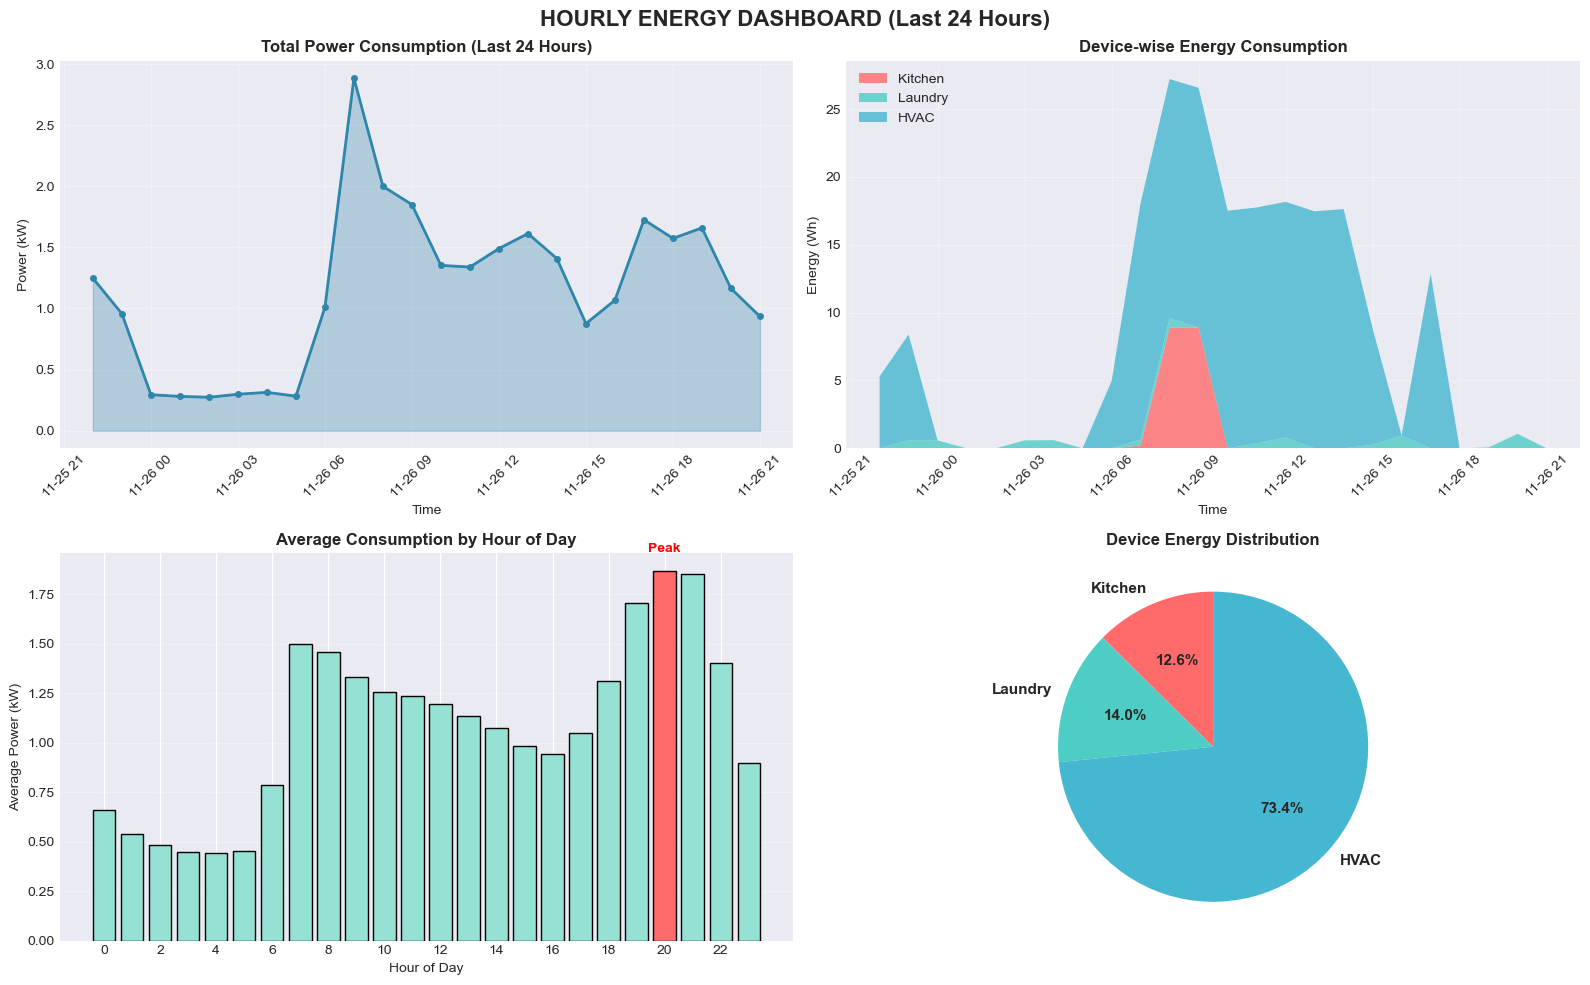

 Saved: dashboard_trends.png


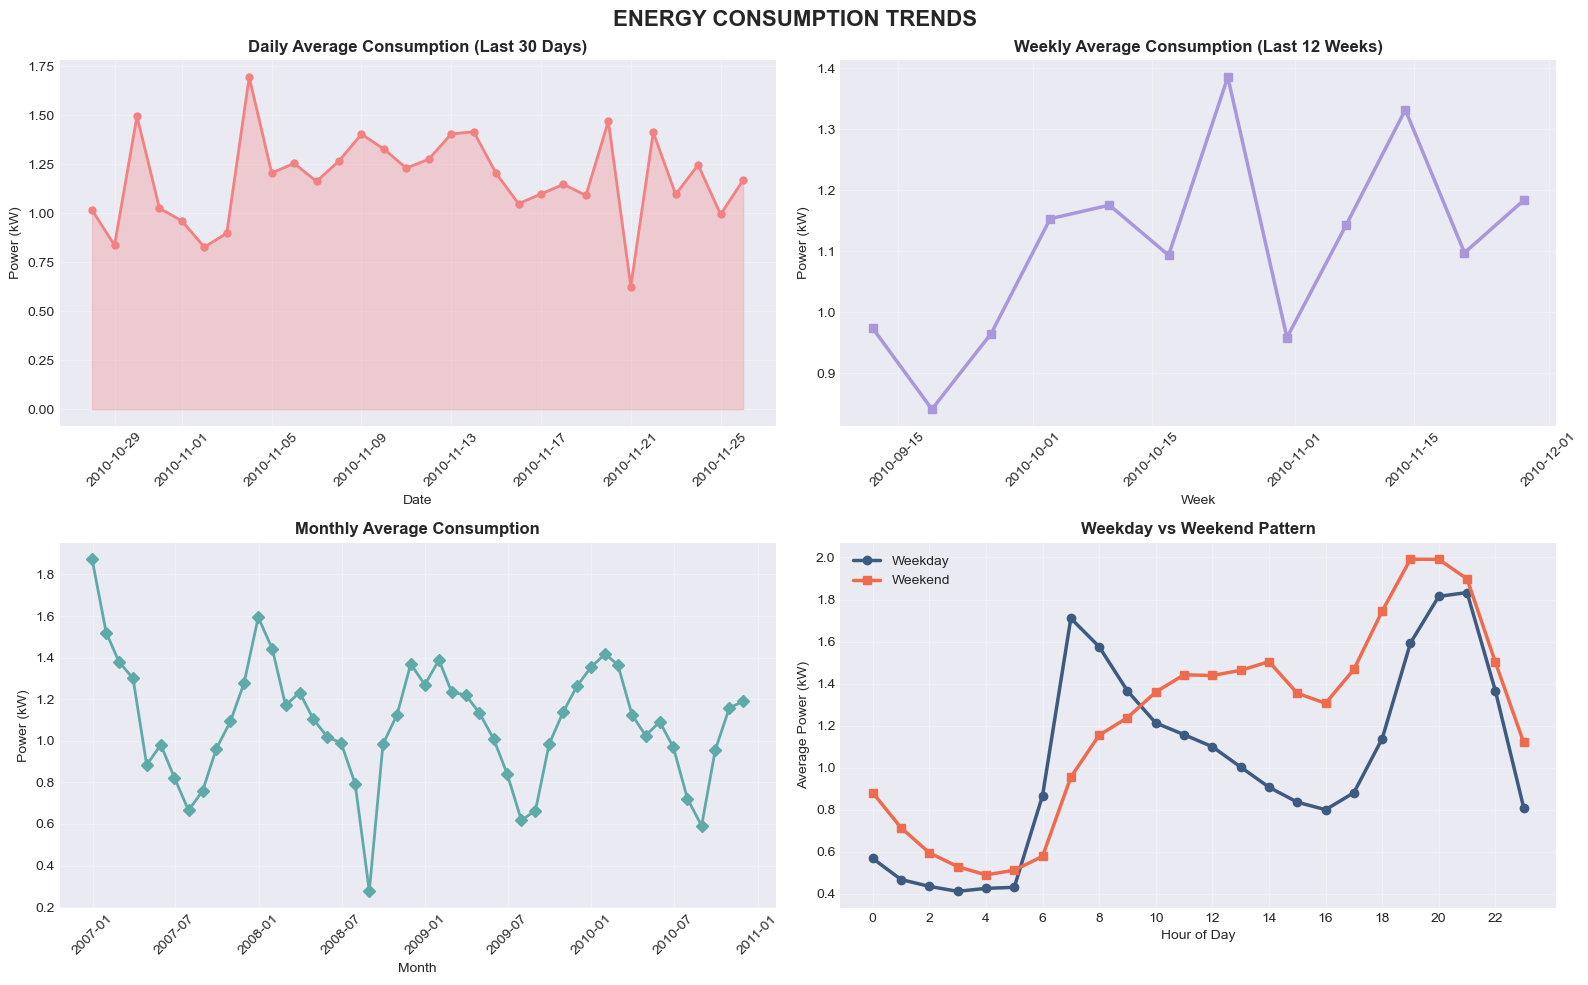

 Saved: dashboard_devices.png


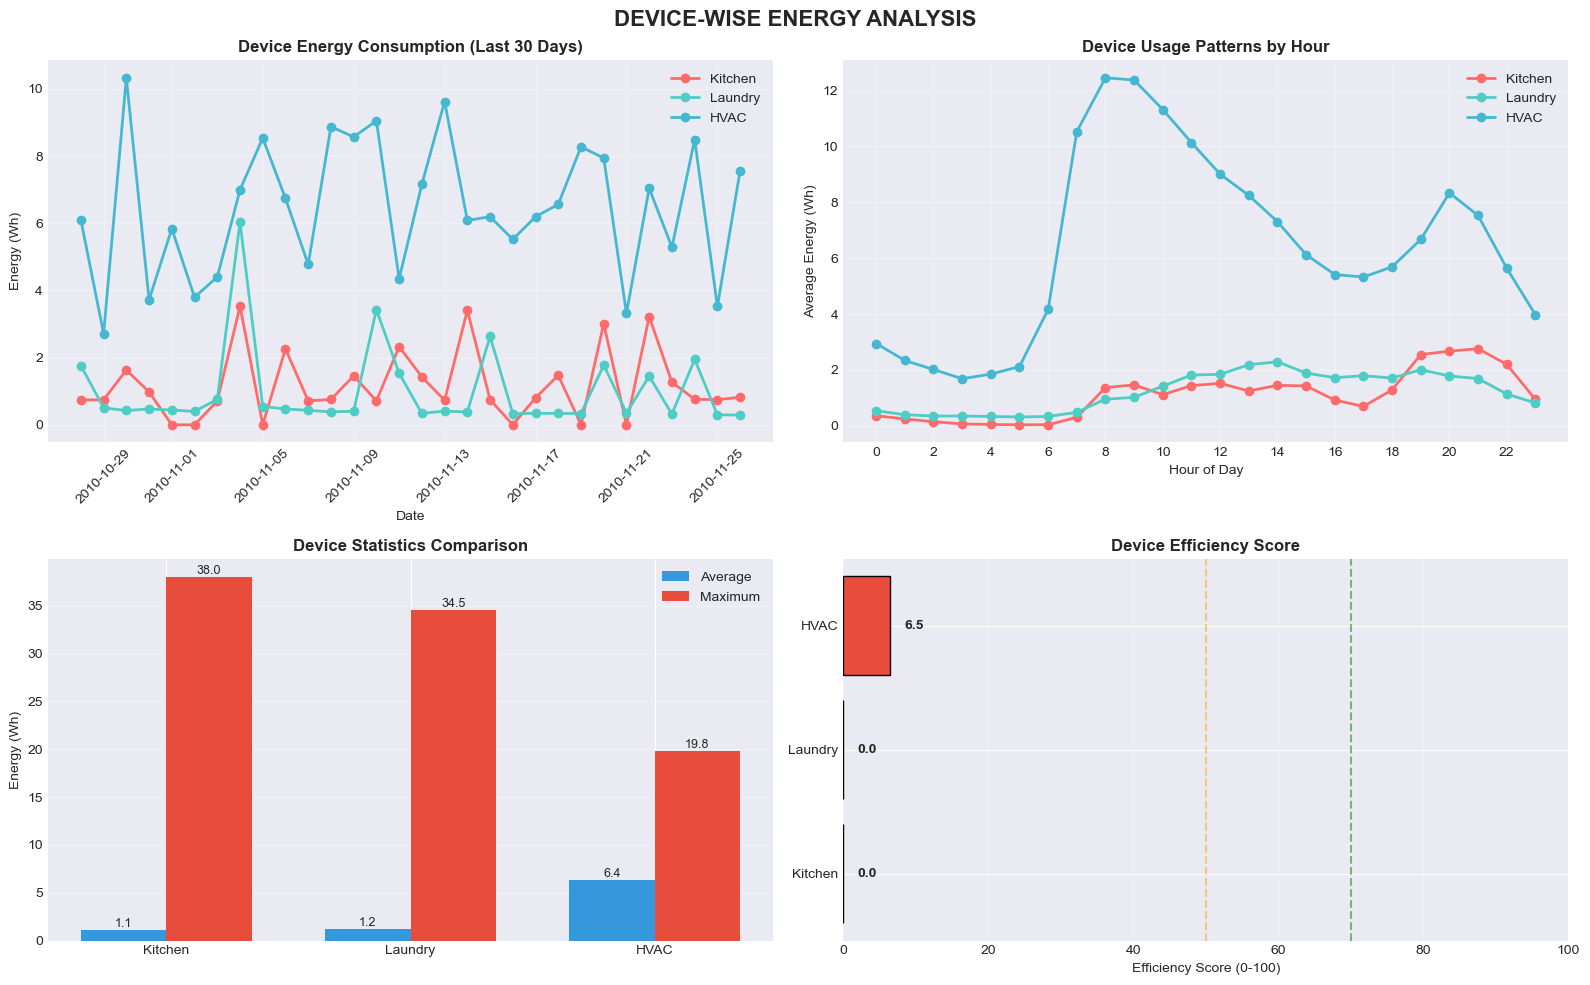

In [6]:
# Creating Dashboard Visualizations

# Dashboard 1: Hourly Consumption (Last 24 hours)
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 10))
fig1.suptitle('HOURLY ENERGY DASHBOARD (Last 24 Hours)', fontsize=16, fontweight='bold')

# Plot 1: Total Power Consumption
ax1 = axes1[0, 0]
ax1.plot(hourly_recent.index, hourly_recent['Global_active_power'],
        linewidth=2, marker='o', markersize=4, color='#2E86AB')
ax1.fill_between(hourly_recent.index, hourly_recent['Global_active_power'],
                alpha=0.3, color='#2E86AB')
ax1.set_title('Total Power Consumption (Last 24 Hours)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Device-wise Breakdown (Stacked Area)
ax2 = axes1[0, 1]
ax2.stackplot(hourly_recent.index,
            hourly_recent['Sub_metering_1'],
            hourly_recent['Sub_metering_2'],
            hourly_recent['Sub_metering_3'],
            labels=device_names,
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1'],
            alpha=0.8)
ax2.set_title('Device-wise Energy Consumption', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy (Wh)')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Hourly Average Pattern
ax3 = axes1[1, 0]
hourly_pattern = df.groupby(df.index.hour)['Global_active_power'].mean()
colors_pattern = ['#FF6B6B' if i == peak_hour else '#95E1D3' for i in hourly_pattern.index]
bars = ax3.bar(hourly_pattern.index, hourly_pattern.values, color=colors_pattern, edgecolor='black')
ax3.set_title('Average Consumption by Hour of Day', fontsize=12, fontweight='bold')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Average Power (kW)')
ax3.set_xticks(range(0, 24, 2))
ax3.grid(axis='y', alpha=0.3)
# Highlight peak hour
ax3.text(peak_hour, hourly_pattern[peak_hour] + 0.1, 'Peak',
        ha='center', fontweight='bold', color='red')

# Plot 4: Device Contribution Pie Chart
ax4 = axes1[1, 1]
device_totals = [device_stats[name]['total'] for name in device_names]
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = ax4.pie(device_totals, labels=device_names, autopct='%1.1f%%',
                                    colors=colors_pie, startangle=90,
                                    textprops={'fontsize': 11, 'fontweight': 'bold'})
ax4.set_title('Device Energy Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('dashboard_hourly.png', dpi=300, bbox_inches='tight')
print(" Saved: dashboard_hourly.png")
plt.show()

# Dashboard 2: Daily/Weekly/Monthly Trends
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))
fig2.suptitle('ENERGY CONSUMPTION TRENDS', fontsize=16, fontweight='bold')

# Plot 1: Daily Trend (Last 30 days)
ax1 = axes2[0, 0]
ax1.plot(daily.index, daily['Global_active_power'], linewidth=2, marker='o',
        markersize=5, color='#F38181')
ax1.fill_between(daily.index, daily['Global_active_power'], alpha=0.3, color='#F38181')
ax1.set_title('Daily Average Consumption (Last 30 Days)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power (kW)')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Weekly Trend (Last 12 weeks)
ax2 = axes2[0, 1]
ax2.plot(weekly.index, weekly['Global_active_power'], linewidth=2.5, marker='s',
        markersize=6, color='#AA96DA')
ax2.set_title('Weekly Average Consumption (Last 12 Weeks)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Week')
ax2.set_ylabel('Power (kW)')
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Monthly Trend (All available months)
ax3 = axes2[1, 0]
ax3.plot(monthly.index, monthly['Global_active_power'], linewidth=2, marker='D',
        markersize=6, color='#5EAAA8')
ax3.set_title('Monthly Average Consumption', fontsize=12, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Power (kW)')
ax3.grid(alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Weekday vs Weekend Comparison
ax4 = axes2[1, 1]
df_copy = df.copy()
df_copy['is_weekend'] = df_copy.index.dayofweek >= 5
weekday_hourly = df_copy[~df_copy['is_weekend']].groupby(df_copy[~df_copy['is_weekend']].index.hour)['Global_active_power'].mean()
weekend_hourly = df_copy[df_copy['is_weekend']].groupby(df_copy[df_copy['is_weekend']].index.hour)['Global_active_power'].mean()

ax4.plot(weekday_hourly.index, weekday_hourly.values, linewidth=2.5, marker='o',
        label='Weekday', color='#3D5A80')
ax4.plot(weekend_hourly.index, weekend_hourly.values, linewidth=2.5, marker='s',
        label='Weekend', color='#EE6C4D')
ax4.set_title('Weekday vs Weekend Pattern', fontsize=12, fontweight='bold')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Average Power (kW)')
ax4.set_xticks(range(0, 24, 2))
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dashboard_trends.png', dpi=300, bbox_inches='tight')
print(" Saved: dashboard_trends.png")
plt.show()

# Dashboard 3: Device-wise Detailed Analysis
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 10))
fig3.suptitle('DEVICE-WISE ENERGY ANALYSIS', fontsize=16, fontweight='bold')

# Plot 1: Device comparison over time (Daily)
ax1 = axes3[0, 0]
daily_devices = df.resample('D')[device_cols].mean().tail(30)
for col, name, color in zip(device_cols, device_names, ['#FF6B6B', '#4ECDC4', '#45B7D1']):
    ax1.plot(daily_devices.index, daily_devices[col], linewidth=2, marker='o',
            label=name, color=color)
ax1.set_title('Device Energy Consumption (Last 30 Days)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Energy (Wh)')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Device hourly patterns
ax2 = axes3[0, 1]
for col, name, color in zip(device_cols, device_names, ['#FF6B6B', '#4ECDC4', '#45B7D1']):
    device_hourly = df.groupby(df.index.hour)[col].mean()
    ax2.plot(device_hourly.index, device_hourly.values, linewidth=2, marker='o',
            label=name, color=color)
ax2.set_title('Device Usage Patterns by Hour', fontsize=12, fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Energy (Wh)')
ax2.set_xticks(range(0, 24, 2))
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Device statistics bar chart
ax3 = axes3[1, 0]
x = np.arange(len(device_names))
width = 0.35
avg_vals = [device_stats[name]['avg'] for name in device_names]
max_vals = [df[col].max() for col in device_cols]

bars1 = ax3.bar(x - width/2, avg_vals, width, label='Average', color='#3498DB')
bars2 = ax3.bar(x + width/2, max_vals, width, label='Maximum', color='#E74C3C')

ax3.set_title('Device Statistics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(device_names)
ax3.set_ylabel('Energy (Wh)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Energy efficiency score
ax4 = axes3[1, 1]
# Calculate efficiency scores (lower is better)
efficiency_scores = []
for name in device_names:
    # Score based on percentage and variability
    score = 100 - (device_stats[name]['percentage'] * 0.5 +
                (df[device_cols[device_names.index(name)]].std() /
                    df[device_cols[device_names.index(name)]].mean() * 50))
    efficiency_scores.append(max(0, min(100, score)))

colors_efficiency = ['#2ECC71' if s >= 70 else '#F39C12' if s >= 50 else '#E74C3C'
                    for s in efficiency_scores]
bars = ax4.barh(device_names, efficiency_scores, color=colors_efficiency, edgecolor='black')
ax4.set_title('Device Efficiency Score', fontsize=12, fontweight='bold')
ax4.set_xlabel('Efficiency Score (0-100)')
ax4.set_xlim(0, 100)
ax4.axvline(x=70, color='green', linestyle='--', linewidth=1.5, alpha=0.5)
ax4.axvline(x=50, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax4.grid(axis='x', alpha=0.3)

for bar, score in zip(bars, efficiency_scores):
    ax4.text(score + 2, bar.get_y() + bar.get_height()/2,
            f'{score:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('dashboard_devices.png', dpi=300, bbox_inches='tight')
print(" Saved: dashboard_devices.png")
plt.show()

 Saved: dashboard_suggestions.png


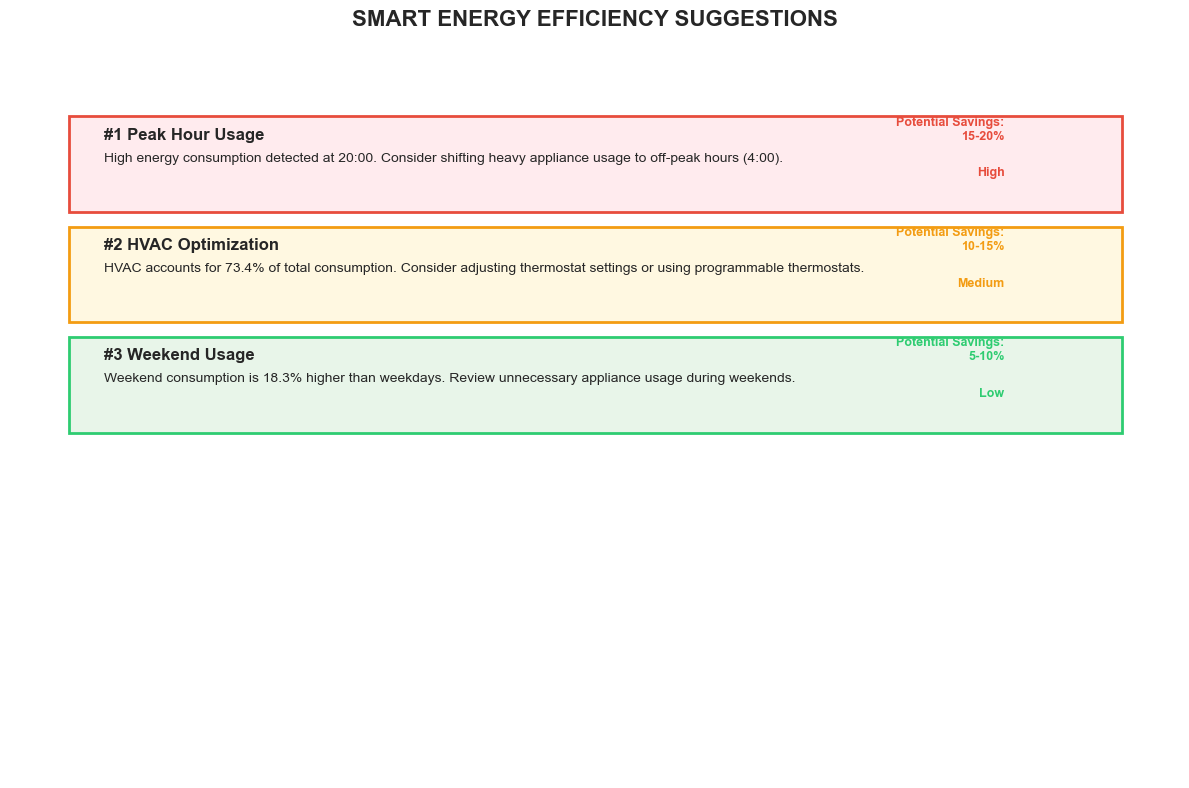

In [7]:
# Creating Smart Suggestions Report

# Create suggestions visualization
fig4, ax = plt.subplots(figsize=(12, 8))
fig4.suptitle('SMART ENERGY EFFICIENCY SUGGESTIONS', fontsize=16, fontweight='bold')

# Hide axes
ax.axis('off')

# Create suggestion cards
y_position = 0.9
for i, suggestion in enumerate(suggestions):
    # Determine color based on severity
    if suggestion['severity'] == 'High':
        bg_color = '#FFEBEE'
        border_color = '#E74C3C'
    elif suggestion['severity'] == 'Medium':
        bg_color = '#FFF8E1'
        border_color = '#F39C12'
    else:
        bg_color = '#E8F5E9'
        border_color = '#2ECC71'
    
    # Draw suggestion box
    box_height = 0.13
    rect = plt.Rectangle((0.05, y_position - box_height), 0.9, box_height,
                        facecolor=bg_color, edgecolor=border_color,
                        linewidth=2, transform=ax.transAxes)
    ax.add_patch(rect)
    
    # Add text
    ax.text(0.08, y_position - 0.03, f"#{i+1} {suggestion['category']}",
            transform=ax.transAxes, fontsize=12, fontweight='bold')
    ax.text(0.08, y_position - 0.06, suggestion['message'],
            transform=ax.transAxes, fontsize=10, wrap=True)
    ax.text(0.85, y_position - 0.03, f"Potential Savings:\n{suggestion['savings']}",
            transform=ax.transAxes, fontsize=9, fontweight='bold',
            ha='right', color=border_color)
    
    # Severity badge
    severity_colors = {'High': '#E74C3C', 'Medium': '#F39C12', 'Low': '#2ECC71'}
    ax.text(0.85, y_position - 0.08, suggestion['severity'], 
            transform=ax.transAxes, fontsize=9, fontweight='bold',
            ha='right', color=severity_colors[suggestion['severity']])
    
    y_position -= (box_height + 0.02)

plt.tight_layout()
plt.savefig('dashboard_suggestions.png', dpi=300, bbox_inches='tight')
print(" Saved: dashboard_suggestions.png")
plt.show()

In [8]:
# Saving Dashboard Data for Web Application

# Save statistics as JSON
import json

dashboard_data = {
    'statistics': {
        'average_power': round(float(stats['avg_power']), 2),
        'max_power': round(float(stats['max_power']), 2),
        'min_power': round(float(stats['min_power']), 2),
        'peak_hour': int(peak_hour),
        'off_peak_hour': int(off_peak_hour),
    },
    'device_stats': {
        name: {
            'average': round(float(device_stats[name]['avg']), 2),
            'total': round(float(device_stats[name]['total']), 2),
            'percentage': round(float(device_stats[name]['percentage']), 2)
        }
        for name in device_names
    },
    'suggestions': suggestions,
    'hourly_pattern': hourly_pattern.to_dict(),
    'last_updated': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('dashboard_data.json', 'w') as f:
    json.dump(dashboard_data, f, indent=4)

print(" Saved: dashboard_data.json")

 Saved: dashboard_data.json
